In [1]:
%env CUDA_VISIBLE_DEVICES=0 # other wise jax will use all your devices 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence

# jax
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

## FLAX
import flax
from flax import linen as nn
from flax.training import train_state 
import optax

# sklearn 
from sklearn import datasets
from sklearn.preprocessing import StandardScaler



env: CUDA_VISIBLE_DEVICES=6


In [ ]:
rng = jax.random.PRNGKey(42)

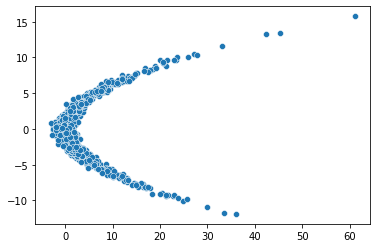

In [27]:
# define a target distribution
def get_points():
    x2 = 0 + 4 * np.random.normal()
    x1 = 0.25 * x2**2 + np.random.normal()
    return x1,x2
x_samples = np.array([get_points() for i in range(1024)])
t_dist = jnp.array(x_samples)
sns.scatterplot(x = x_samples[:,0],y = x_samples[:,1])
plt.savefig('images/target_dist.png', bbox_inches='tight',dpi=100)

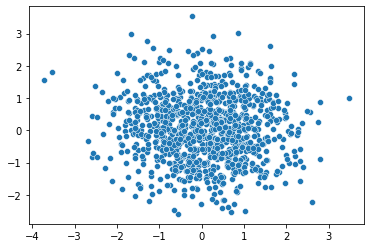

In [28]:
# this is our base distribtion, which we aim to map onto the target distribution
cov = np.array([[1, 0], [0, 1]])
mean = np.array([0,0])

b_dist = jax.random.multivariate_normal(rng,mean,cov,shape=(1024,))
sns.scatterplot(x=b_dist [:,0],y=b_dist [:,1])
plt.savefig('images/normal_dist.png', bbox_inches='tight',dpi=100)

# Define 2 types of layers 
    - leaky relu
    - real nvp

In [32]:
class LeakyRelu(nn.Module):        
    layer_type = "leaky_relu"
    def setup(self):
        self.alpha = self.param('alpha', nn.initializers.uniform(0.9),
                                         (1,))
    def __call__(self, z, ldj,rng, reverse=False):
        rng, new_rng = jax.random.split(rng, 2)
        if not reverse:
            dj = jnp.where(z>0, 1, self.alpha)
            z = jnp.where(z>0, z, self.alpha * z)
            ldj += jnp.log(jnp.absolute(dj)).sum(axis=[1])
            return z, ldj, new_rng
        else:
            z = jnp.where(z>0, z, z/self.alpha)
            dj = jnp.where(z>0, 1, 1/self.alpha)
            ldj += jnp.log(jnp.absolute(dj)).sum(axis=[1])
            return z, ldj, new_rng
        


FrozenDict({
    params: {
        alpha: DeviceArray([0.5432298], dtype=float32),
    },
})
ldj list: [-0.6102228  0.         0.        ...  0.        -0.6102228 -0.6102228]


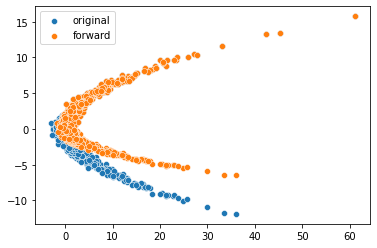

In [35]:
# initialize an lru layer 
lru = LeakyRelu()
rng, inp_rng, init_rng = jax.random.split(rng, 3)
params = lru.init(init_rng,x_samples,0,inp_rng)
print(params)

# go forward and check LDJ
z = t_dist
ldj = jnp.zeros(len(z))
sns.scatterplot(x= z[:,0], y = z[:,1],label="original")
z,ldj,rng = lru.apply(params,z,0,rng,reverse=False)
ldj_relu = ldj # for later use
sns.scatterplot(x= z[:,0], y = z[:,1],label="forward")
print("ldj list:", ldj)
plt.savefig('images/relu_effect.png', bbox_inches='tight',dpi=100)

# Affine layer

In [7]:
# credit https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html
class SimpleNet(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x
    
class CouplingLayer(nn.Module):
    network : nn.Module  # NN to use in the flow for predicting mu and sigma
    mask : np.ndarray  # Binary mask where 0 denotes that the element should be transformed, and 1 not.
    c_in : int  # Number of input channels
    layer_type = "Scale and Shift"
    def setup(self):
        self.scaling_factor = self.param('scaling_factor',
                                         nn.initializers.zeros,
                                         (self.c_in,))

    def __call__(self, z, ldj, rng, reverse=False):
        # Apply network to masked input
        z_in = z * self.mask
        nn_out = self.network(z_in)
        s, t = nn_out.split(2, axis=-1)
        # Stabilize scaling output
        s_fac = jnp.exp(self.scaling_factor).reshape(1, -1)
        s = nn.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * jnp.exp(s)
            ldj += s.sum(axis=[1])
        else:
            z = (z * jnp.exp(-s)) - t
            ldj -= s.sum(axis=[1])

        return z, ldj, rng
    


In [8]:
# single layer network
CL = CouplingLayer(network = SimpleNet(num_hidden=8,num_outputs=2),mask = jnp.array([0,1]) ,c_in=1)
rng, inp_rng, init_rng = jax.random.split(rng,3)
inp = jax.random.normal(inp_rng,(3,2))
params = CL.init(init_rng,inp,0,inp_rng)

# apply it 
rng, inp_rng, init_rng = jax.random.split(rng,3)
out, ldj, rng = CL.apply(params,inp,ldj_relu[0:3],inp_rng)
ldj

DeviceArray([-0.0574039 , -0.7861753 , -0.06788543], dtype=float32)

In [9]:
# multi layer network
class PointFlow(nn.Module):
    flows : Sequence[nn.Module]
            
    def __call__(self, z, rng, intermediate=False,training=True):
        ldj = 0 
        rng, rng_new = jax.random.split(rng,2)
        for flow in self.flows:
            z, ldj, rng = flow(z, ldj, rng, reverse=False)
        return z, ldj, rng_new
    
    def sample(self,rng,num = 1, intermediate = False):
        ldj = 0
        rng, new_rng = jax.random.split(rng,2)
        z = jax.random.normal(rng,shape=[num,2])
        intermediate_layers = [z]
        for flow in reversed(self.flows):
            z, ldj, rng = flow(z,ldj,rng,reverse=True)
            if intermediate: # if we want to see the intermediate resluts
                intermediate_layers.append(z)
        return z, rng, intermediate_layers
        
flow_layers = []
for i in range(9):
    flow_layers += [LeakyRelu()]
    flow_layers += [CouplingLayer(network = SimpleNet(num_hidden=4,num_outputs=2),mask = jnp.array([0,1]) if i%2 else jnp.array([1,0]),c_in=1)]

    
model = PointFlow(flow_layers)
params = model.init(init_rng,inp,inp_rng,intermediate=True)

## Training

In [10]:
optimizer = optax.adamw(learning_rate=0.0001)
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

# loss calculation
def loss_calc(state, params, rng, batch):
    rng, init_rng = jax.random.split(rng,2)
    z, ldj, rng  = state.apply_fn(params,batch,rng)
    # loss is ldj + log(probability of points in a normal distribution)
    log_pz = jax.scipy.stats.norm.logpdf(z).sum(axis=[1])
    log_px = ldj + log_pz
    nll = -log_px
    return nll.mean(), rng
nll, rng = loss_calc(model_state,params,rng,inp)
nll, rng

(DeviceArray(9.220764, dtype=float32),
 DeviceArray([1356509075, 2494960792], dtype=uint32))

In [11]:
@jax.jit
def train_step(state,rng,batch):
    rng, init_rng = jax.random.split(rng,2)
    grad_fn = jax.value_and_grad(loss_calc,  # Function to calculate the loss
                             argnums=1,  # Parameters are second argument of the function
                             has_aux=True  # Function has additional outputs, here accuracy
                            )
#     batch = jax.random.choice(rng,batch,shape=[1000])
    # Determine gradients for current model, parameters and batch
    (loss,rng), grads = grad_fn(state, state.params, rng, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, rng, loss

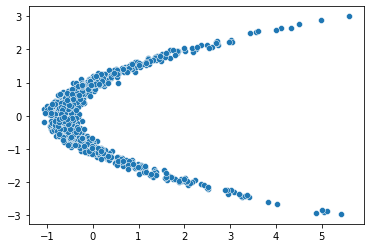

In [26]:
X, y = datasets.make_circles(n_samples=5000, factor=0.5, noise=0.05)
X = t_dist
X = StandardScaler().fit_transform(X)
sns.scatterplot(x= X[:,0], y = X[:,1])
plt.savefig('images/target_dist.png', bbox_inches='tight',dpi=100)

In [ ]:
state = model_state

min_loss,patience = np.inf,10000
for i in range(1000000):
    state,rng,loss = train_step(state,rng,X)
    
    if i%10000==0:
        X_flow = model.apply(state.params,X,inp_rng)[0]
        sns.scatterplot(x= X_flow[:,0], y = X_flow[:,1],label="forward")
        plt.show()
        
    if loss+1e-8>min_loss:
        patience -= 1
        if patience == 0:
            break
    else:
        min_loss = loss
        patience = 10000  
        
    print("iter %d patience %d loss %f"%(i,patience, loss) , end="\r")
    

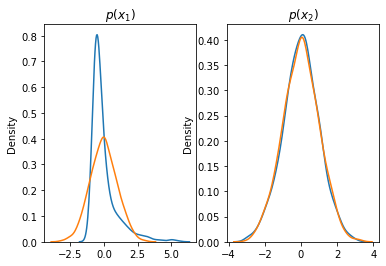

In [15]:
plt.subplot(1, 2, 1)
sns.kdeplot(x=X[:,0],label="data")
sns.kdeplot(x=X_flow[:,0],label="flow")
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(x=X[:,1],label="data")
sns.kdeplot(x=X_flow[:,1],label="flow")
plt.title(r'$p(x_2)$')
plt.show()

### Sampling

In [16]:
trained_model = model.bind(state.params)

DeviceArray(-2.853447, dtype=float32)

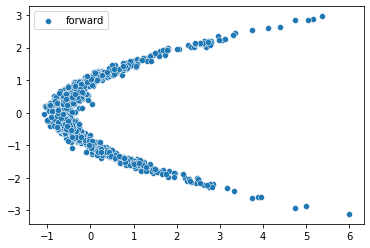

In [17]:
sample_list,rng, mid_layers = trained_model.sample(rng,num=1000,intermediate=True)

g = sns.scatterplot(x= sample_list[:,0], y = sample_list[:,1],label="forward")
# plt.ylim([-3, 3])
# plt.xlim([-2, 2])

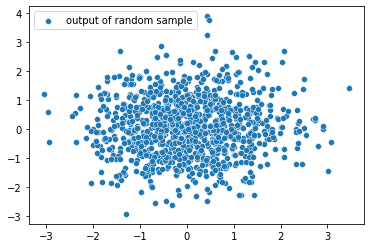

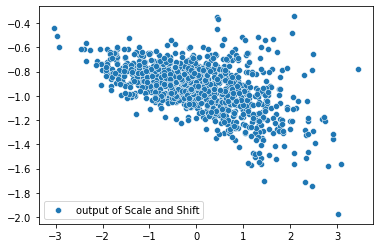

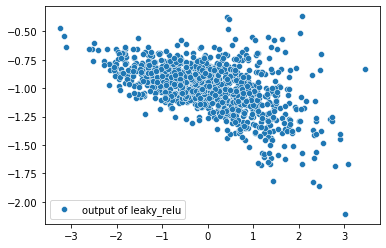

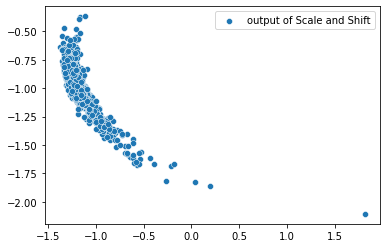

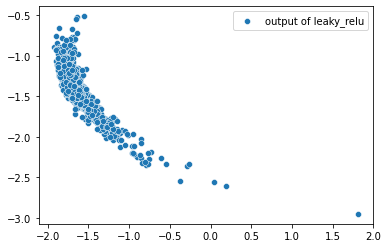

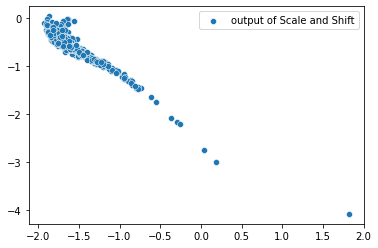

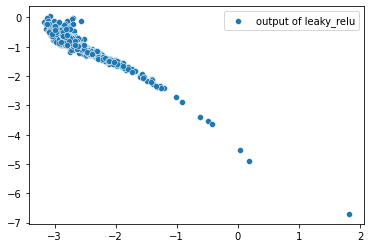

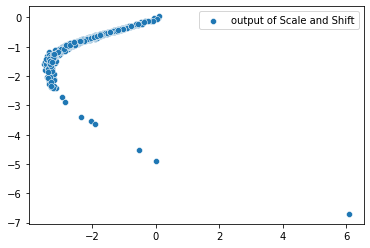

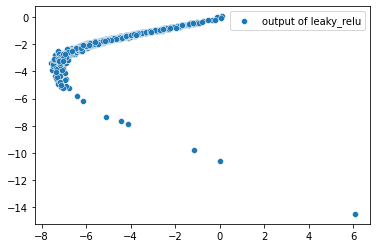

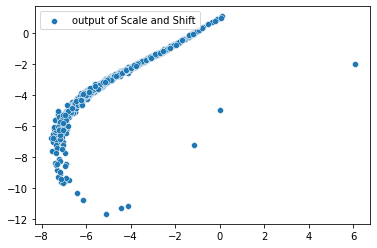

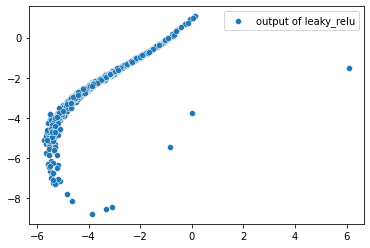

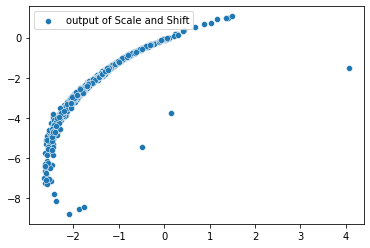

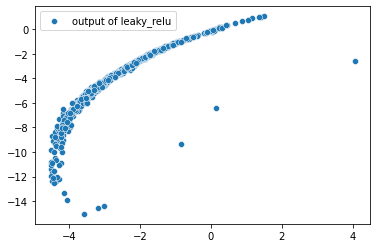

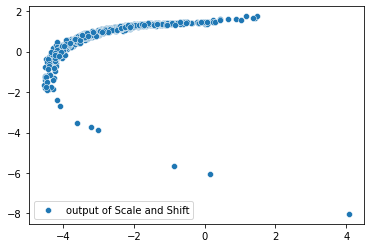

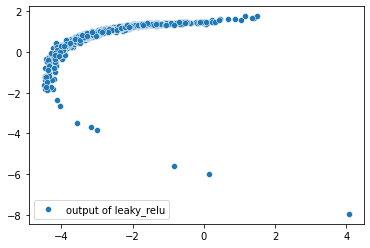

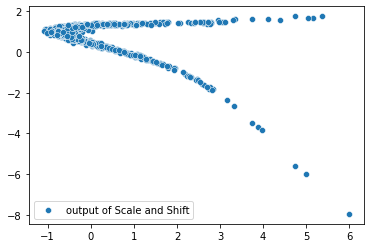

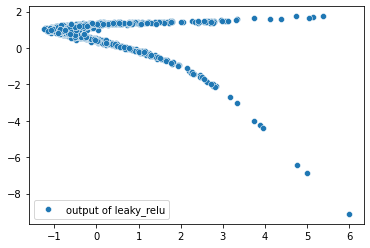

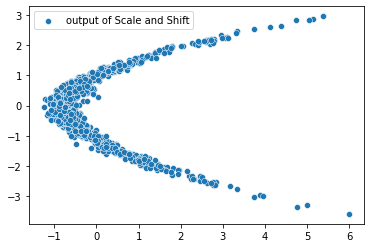

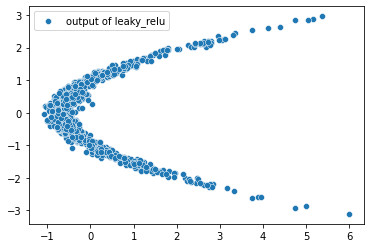

In [24]:
layers = ["random sample"] + [model.flows[i].layer_type for i in range(len(model.flows))][::-1] # order of generation layers

zs = [] #going to save this and make an animation in the animation notebook
for i,out in enumerate(mid_layers):
    sns.scatterplot(x= out[:,0], y = out[:,1],label = "output of " + layers[i])
    zs.append(out)
    plt.show()
np.save("transformations",np.array(zs))